--- BẮT ĐẦU XỬ LÝ DỮ LIỆU ---
Đang làm sạch dữ liệu...
Đang tạo giỏ hàng...
Kích thước giỏ hàng: (9729, 3827)

--- BẮT ĐẦU SO SÁNH ---
1. Đang chạy Apriori (sẽ hơi lâu)...


/opt/conda/lib/python3.7/site-packages/mlxtend/frequent_patterns/fpcommon.py:115: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  DeprecationWarning,


-> Apriori hoàn thành trong: 2.4715 giây
2. Đang chạy FP-Growth...


/opt/conda/lib/python3.7/site-packages/mlxtend/frequent_patterns/fpcommon.py:115: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  DeprecationWarning,


-> FP-Growth hoàn thành trong: 1.7302 giây


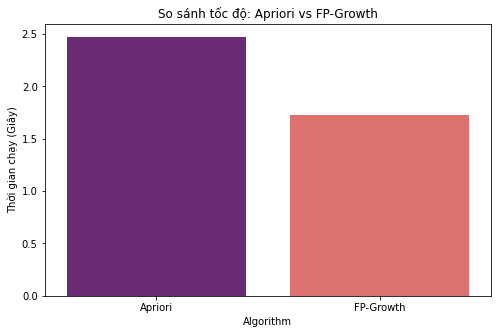


--- KẾT QUẢ SINH LUẬT TỪ FP-GROWTH ---
Top 10 luật mạnh nhất tìm được bởi FP-Growth:
                             antecedents  \
47                 (BATHROOM METAL SIGN)   
46                   (TOILET METAL SIGN)   
29   (RED 3 PIECE MINI DOTS CUTLERY SET)   
28  (BLUE 3 PIECE MINI DOTS CUTLERY SET)   
63               (HEART OF WICKER LARGE)   
62               (HEART OF WICKER SMALL)   
45    (SINGLE HEART ZINC T-LIGHT HOLDER)   
44   (HANGING HEART ZINC T-LIGHT HOLDER)   
35         (WOODEN FRAME ANTIQUE WHITE )   
34   (WOODEN PICTURE FRAME WHITE FINISH)   

                             consequents       lift  confidence  
47                   (TOILET METAL SIGN)  22.511907    0.640950  
46                 (BATHROOM METAL SIGN)  22.511907    0.779783  
29  (BLUE 3 PIECE MINI DOTS CUTLERY SET)  20.970292    0.650943  
28   (RED 3 PIECE MINI DOTS CUTLERY SET)  20.970292    0.685430  
63               (HEART OF WICKER SMALL)  19.114124    0.719064  
62               (HEART OF WICKER

In [4]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

# --- 1. CẤU HÌNH & CLASS XỬ LÝ (Dùng lại của Lab 1) ---
file_path = "/kaggle/input/online-retail-ii-uci/online_retail_II.csv" # Kiểm tra lại đường dẫn này trên máy bạn

class DataCleaner:
    def __init__(self, df):
        self.df = df
    def clean_data(self):
        print("Đang làm sạch dữ liệu...")
        self.df.rename(columns={'Invoice': 'InvoiceNo', 'Customer ID': 'CustomerID', 'Price': 'UnitPrice'}, inplace=True)
        self.df['InvoiceNo'] = self.df['InvoiceNo'].astype('str')
        self.df = self.df[~self.df['InvoiceNo'].str.contains('C')]
        self.df = self.df[self.df['Country'] == 'United Kingdom']
        self.df = self.df.dropna(subset=['CustomerID'])
        self.df = self.df[(self.df['Quantity'] > 0) & (self.df['UnitPrice'] > 0)]
        return self.df

class BasketPreparer:
    def __init__(self, df):
        self.df = df
    def create_basket(self):
        print("Đang tạo giỏ hàng...")
        basket = (self.df.groupby(['InvoiceNo', 'Description'])['Quantity']
                  .sum().unstack().reset_index().fillna(0)
                  .set_index('InvoiceNo'))
        return basket
    def encode_units(self, x):
        return 1 if x >= 1 else 0

# --- 2. CHẠY PIPELINE ---
try:
    # Đọc và xử lý dữ liệu
    print("--- BẮT ĐẦU XỬ LÝ DỮ LIỆU ---")
    if file_path.endswith('.xlsx'): df = pd.read_excel(file_path)
    else: df = pd.read_csv(file_path)
    
    # Lần này ta lấy nhiều dữ liệu hơn chút (200k dòng) để thấy rõ sự khác biệt tốc độ
    # FP-Growth chịu tải tốt hơn Apriori nên không sợ crash nhanh
    df = DataCleaner(df).clean_data().head(200000) 
    
    basket = BasketPreparer(df).create_basket()
    basket_sets = basket.applymap(BasketPreparer(df).encode_units)
    if 'POSTAGE' in basket_sets.columns: basket_sets.drop('POSTAGE', inplace=True, axis=1)
    
    print(f"Kích thước giỏ hàng: {basket_sets.shape}")

    # --- 3. SO SÁNH APRIORI vs FP-GROWTH ---
    print("\n--- BẮT ĐẦU SO SÁNH ---")
    
    # a. Chạy Apriori
    print("1. Đang chạy Apriori (sẽ hơi lâu)...")
    start_time = time.time()
    res_apriori = apriori(basket_sets, min_support=0.02, use_colnames=True)
    apriori_time = time.time() - start_time
    print(f"-> Apriori hoàn thành trong: {apriori_time:.4f} giây")

    # b. Chạy FP-Growth
    print("2. Đang chạy FP-Growth...")
    start_time = time.time()
    res_fpgrowth = fpgrowth(basket_sets, min_support=0.02, use_colnames=True)
    fpgrowth_time = time.time() - start_time
    print(f"-> FP-Growth hoàn thành trong: {fpgrowth_time:.4f} giây")

    # --- 4. TRỰC QUAN HÓA SO SÁNH ---
    # Vẽ biểu đồ thời gian chạy
    comparison = pd.DataFrame({
        'Algorithm': ['Apriori', 'FP-Growth'],
        'Time (Seconds)': [apriori_time, fpgrowth_time]
    })
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Algorithm', y='Time (Seconds)', data=comparison, palette='magma')
    plt.title('So sánh tốc độ: Apriori vs FP-Growth')
    plt.ylabel('Thời gian chạy (Giây)')
    plt.show()

    # --- 5. SINH LUẬT TỪ FP-GROWTH (Phần nộp báo cáo) ---
    print("\n--- KẾT QUẢ SINH LUẬT TỪ FP-GROWTH ---")
    rules = association_rules(res_fpgrowth, metric="lift", min_threshold=1)
    top_rules = rules[(rules['lift'] >= 1.2) & (rules['confidence'] >= 0.3)]
    
    print("Top 10 luật mạnh nhất tìm được bởi FP-Growth:")
    print(top_rules.sort_values(by='lift', ascending=False).head(10)[['antecedents', 'consequents', 'lift', 'confidence']])

except Exception as e:
    print("Lỗi:", e)